# Setting Parameters for Frangi Vessel Enhancement-based Segmentation

This is the preferred method for dirty images, though computationally it is a bit more expensive than than the thresholding based method. 

Use this script to make decisions about critical parameters based on the images you capture. Base this on 5-10 images that have the characteristics of:
- Similar, representative color profile
- Variety of challenges. For hyphae detection, this includes: dirty areas, hyphae-like objects (skinny, long, but unstained), fat objects, blurry/thin hyphae, etc.

Then, either:
- Update an `frangi_segmentation_analysis.py` script for your image loop. 
- Run `frangi_image_loop()` at the end of this notebook.

The image loop function saves a dataframe to a .CSV with columns:
- Image: Identifier of each image
- NObjects: Number of individual objects measured in Image (without diameter binning)
- Diameter: Mean diameter of all objects in Image(in pixels)
- Length: Total length of all objects in Image (in pixels)
Alternatively, objects can be binned by diameter class. This returns a dataframe specifying length by diameter class, using similarly intuitive column names. 

## Steps
1. Load images and libraries
2. Equalize exposure
3. View candidate colorspace bands
4. Pull the band of interest
5. Enhance vessels with the frangi filter
6. Adaptive threshold to segment frangi filter
7. Filter based on color
8. Filter based on geometry
9. Filter based on hollowness
10. Combine filters and check results
11. Remove small holes and close small gaps
12. Skeletonize
13. Summarize
14. Export parameters
15. Test full analysis for stability
16. Run loop

## 1. Load images and libraries

Image: 107r20027.tif
Image Dimensions [length, width, bands]: [1741, 1741, 3]


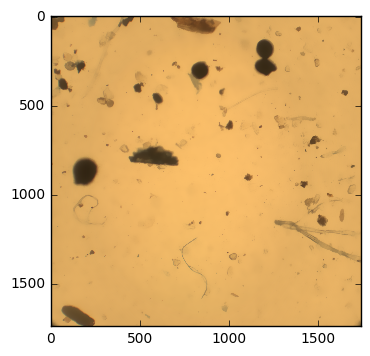

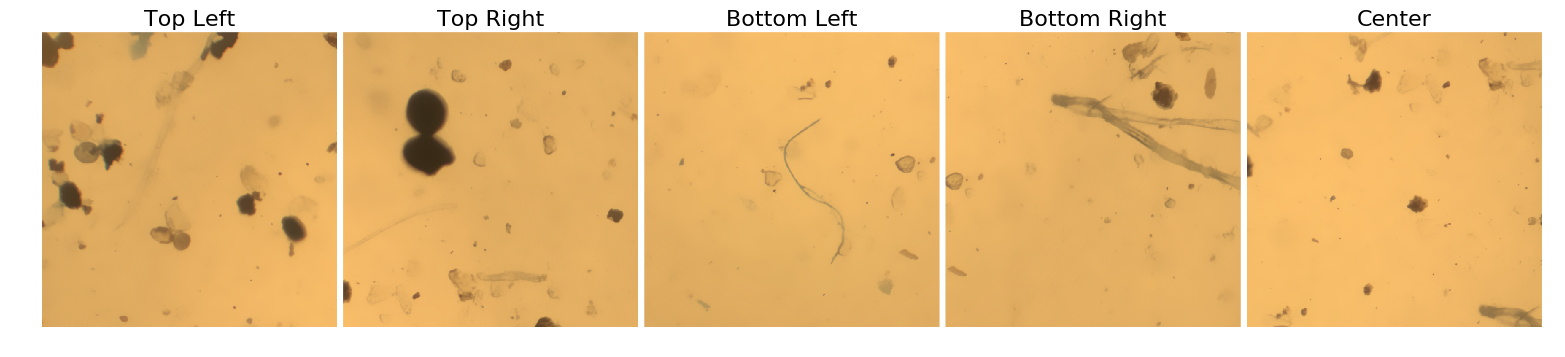

In [82]:
%matplotlib inline

#########################################################################################
dir_in = "/home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed/"
file_in = ["101r10022.tif", "101r20006.tif", "101r20116.tif", "101r30042.tif", "107r20011.tif", 
           "107r20027.tif", "107r30092.tif", "107r30094.tif", "107r30118.tif", "108r10030.tif"]
selection = 5  # what do you want to work on for the moment? Select the image from file_in.

# Zoom to these bounding boxes for easy viewing.
zoom_topleft =     {'xmin' : 0,
                    'xmax' : 700,
                    'ymin' : 0,
                    'ymax' : 700}
zoom_topright =    {'xmin' : 1000,
                    'xmax' : 1700,
                    'ymin' : 0,
                    'ymax' : 700}
zoom_bottomleft =  {'xmin' : 400,
                    'xmax' : 1100,
                    'ymin' : 1040,
                    'ymax' : 1740}
zoom_bottomright = {'xmin' : 1000,
                    'xmax' : 1700,
                    'ymin' : 1000,
                    'ymax' : 1700}
zoom_center=       {'xmin' : 700,
                    'xmax' : 1400,
                    'ymin' : 500,
                    'ymax' : 1200}
plot = True
#########################################################################################

from matplotlib import pyplot as plt
from skimage import io, color, filters, draw, morphology, exposure, img_as_float, img_as_ubyte, restoration, measure
import pyroots as pr
import numpy as np
from scipy import ndimage
import warnings
import pandas as pd
import os

image = io.imread(dir_in + file_in[selection])

print("Image: " + file_in[selection] + "\nImage Dimensions [length, width, bands]: " + str([i for i in image.shape]))

if plot is True:
    img = image
    plt.imshow(img)
    zoom_list = [zoom_topleft, zoom_topright, zoom_bottomleft, zoom_bottomright, zoom_center]
    zoom_names = ['Top Left', 'Top Right', 'Bottom Left', 'Bottom Right', 'Center']
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)

## 2. Equalize Exposure?
Does your image have uneven brightness across it? Many microscope images show this, where the center of the image has a brighter background than the edges. If so, and you want to use color filtering, equalizing exposure improves results by normalizing colors across the image. However, note that this function is rather slow; creating a GIMP script would be faster. 

Run this function independently of the frangi_analysis function/loop and inspect results manually, to ensure nothing weird happens.

See <a href="https://github.com/pme1123/pyroots/blob/master/pyroots/image_manipulation.py">documentation</a>. Critical parameters include whether to stretch values (`stretch=True`; default `False`), which will lead to weird behavior across large numbers of images, and whether `dark_objects=True`. May invert bands for light objects on dark backgrounds; if so, (1-band) will revert to original ranking. Default behavior should be satisfactory otherwise.

In [30]:
#########################################################################################
equalize_brightness = False  # recommended for image quality
stretch = False
#########################################################################################


if equalize_brightness is True:
    temp = [pr.equalize_exposure(i, stretch=stretch) for i in pr.img_split(image)]
    out = np.zeros(image.shape)
    for j in range(len(temp)):  # remake into 3d array
        out[:, :, j] = temp[j]
    image = out.copy()

    img = image
    plt.imshow(img)
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)

## 3. Select the band of the colorspace for identifying candidate objects
Choose a band that shows hyphae clearly and consistently. Some distinction between hyphae and non-hyphae objects helps but is not essential. Objects should not be partly outlined in higher (lighter) values; for this reason, avoid chroma type bands like hue of hsv or a\* and b\* of l\*a\*b\*. For analine blue stain in a microscope, the red band of rgb is good. 

In general, a single band is sufficient for identifying candidate objects.

In [31]:
####################################################
colorspaces = ['rgb','hsv','lab','xyz','luv', 'hed'] # add or remove whatever you're curious about. See skimage.color.rgb2*()
colorspace_zoom = zoom_center
####################################################

bandviewer = False
if bandviewer is True: [pr.band_viewer(image, i, colorspace_zoom) for i in colorspaces]

## 4. Pull out the band of interest
Identify the colorspace and band that seems to show objects clearly, while also highlighting differences from non-objects.

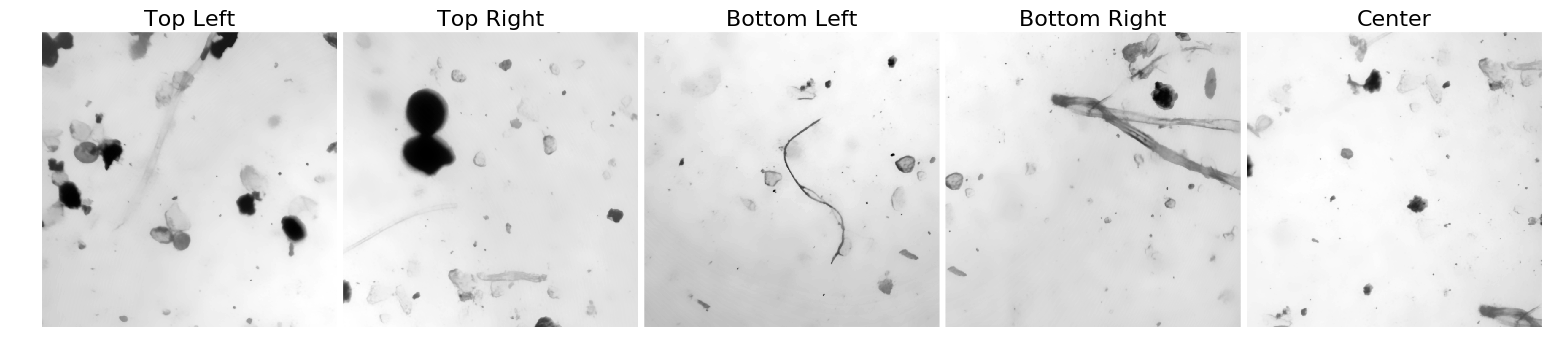

In [32]:
#########################################################################################
colors = {'colorspace' : 'rgb',
          'band'       : 0}      # rgb: 0 = red, 1 = green, 2 = blue
#########################################################################################

# convert colorspace if necessary
if colors['colorspace'].lower() != 'rgb':
    band = getattr(color, "rgb2" + colors['colorspace'])(image)
else:
    band = image.copy()
    
band = pr.img_split(band)[colors['band']]

img = band
if plot is True: pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)

## 5. Run frangi filter

The frangi filter enhances ridges/edges of a series of widths and set contrast from neighboring objects. Width is controlled by `sigma`, dictated by `scale_range` and `scale_step`. Sensitivity is controlled by `beta2`. See <a href="http://scikit-image.org/docs/dev/api/skimage.filters.html"> documentation</a>.

Pick a `scale_range` that highlights whole hyphae and edges of larger objects. For hyphae at 100x, a scale range of `(2, 8)` works well. `scale_step` should sufficiently cover width classes. `beta1` should be nearly 1 for best behavior. `beta2` controls the sensitivity, and should be set so that objects are clear, and touching objects have an area of lower response between them. The value probably will be close to 0.05. Expect lots of spurrious, small objects that will be removed with further filtering. 

Max: 0.999988707604
Min: 0.0


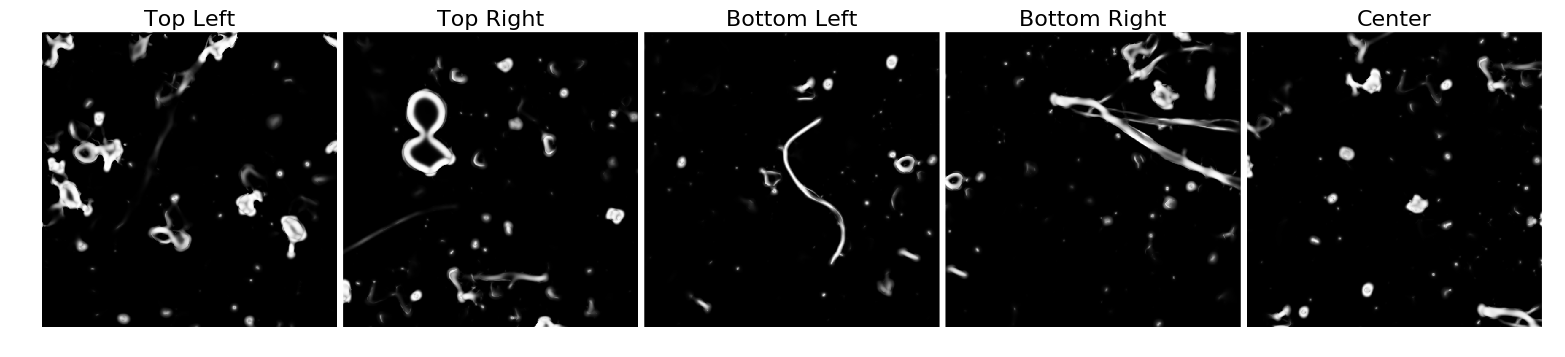

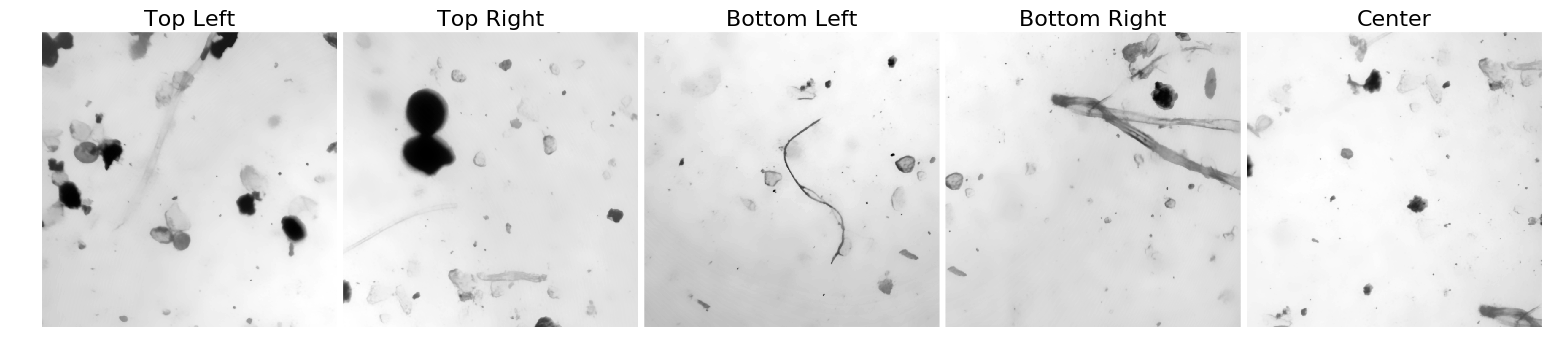

In [65]:
#########################################################################################
frangi_args = {'scale_range'  : (2, 8),  # sigmas for running the filter. Wider enhances wider objects; narrow enhances narrow objects.
               'scale_step'   : 1,       # step between sigmas in the scale range.
               'beta1'        : 0.99,    # correction [0,1] toward linear vs ring-like. Want close to 1.
               'beta2'        : 0.03,    # sensitivity to low-contrast areas. Smaller is more sensitive.
               'black_ridges' : True}    # dark objects on light background?
#########################################################################################


frangi = filters.frangi(band, **frangi_args)  # detect black or white ridges

if plot is True:
    print("Max: {!s}\nMin: {!s}".format(frangi.max(), frangi.min()))
#     print(frangi.min())
    img = frangi
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)
    # img = rescaled[0] > np.percentile(rescaled[0], 98)
    img = band
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)

## 6. Adaptive threshold the frangi filter
Now identify objects and edges using an adaptive threshold. The advantage of this is, it separates distinct objects from each other due to their combined high response giving a locally high thresholed. For it to work, the sensitivity of the frangi filter must be low enough to give low responses where objects touch. 

Strategy:
* `block_size` : Defines the local neighborhood for thresholding. Should be small enough to be responsive to the local neighborhood, but large enough to avoid splitting wider objects. For frangi vessel range of [2:8], a `block_size` of 29 is good.
* `offset` : Sets the threshold for the area. Range [0:1] for float images like these. Highly sensitive. The ideal value proably will be between 0.05 and 0.1.

The image shows separate colors for each individual object (via `scipy.ndimage.label`). Use this to evaluate connectivity among objects. See <a href="http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.threshold_adaptive"> documentation</a>.

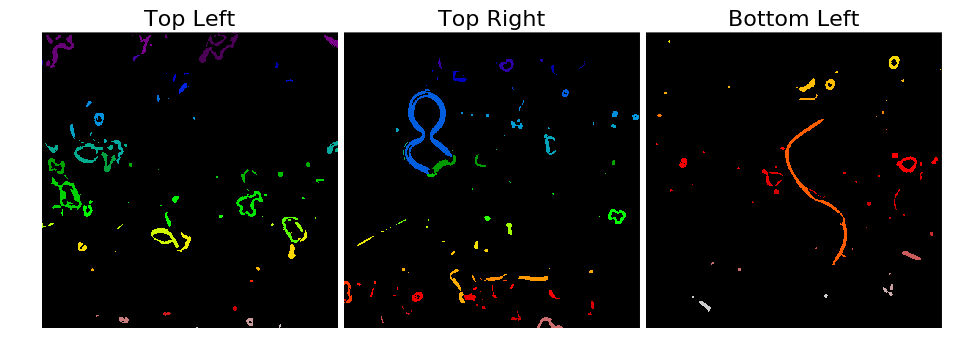

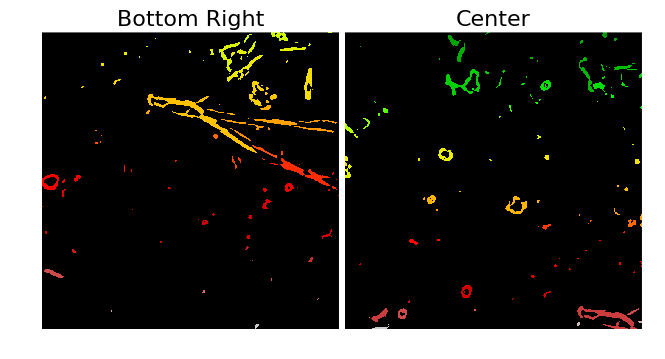

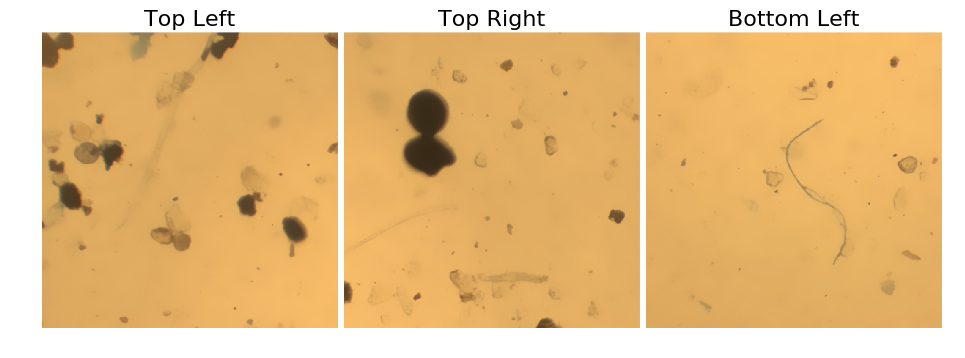

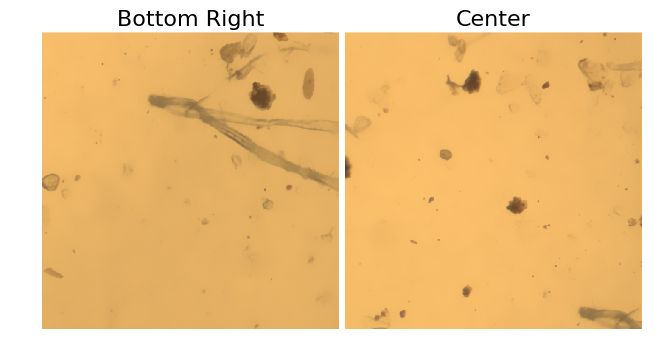

In [66]:
#########################################################################################
threshold_args = {'block_size' : 29,   # small enough to respond strongly to the local neighborhood, large enough to avoid hollowing objects
                  'offset'     : 0.09}  # high enough to separate touching objects, but low enough to maintain connectivity
#########################################################################################

thresh = 1 - (frangi/frangi.max())  # invert, rescale so vessels are dark.
thresh = ~filters.threshold_adaptive(thresh, **threshold_args)  # invert so objects are True

if plot is True:
    img = ndimage.label(thresh)[0]
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list[0:3]], zoom_names[0:3], color_map = "spectral")
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list[3:5]], zoom_names[3:5], color_map = "spectral")
    img = image
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list[0:3]], zoom_names[0:3], color_map = "spectral")
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list[3:5]], zoom_names[3:5], color_map = "spectral")

## 7. Filter objects by color values
If staining, objects should be a consistent color if not a consistent saturation. This provides a way of distinguishing real objects from spurrious ones. The algorithm determines whether each pixel of a band array falls within range, then computes the area of those pixels within an object meets a minimum percent of the total area of each object. See <a href="https://github.com/pme1123/pyroots/blob/master/pyroots/noise_filters.py"> documentation</a>. If working with a grayscale image or want to feed the band manually, choose `grayscale_filter` instead of `color_filter`. 

Strategy:
1. Choose a `target_band` from a `colorspace` where real objects and false objects don't overlap too much. For the example image, I chose blue in RGB and saturation in HSV.
2. Determine the `low` and `high` range of values that real objects should take.
3. Set a minimum `percent` of pixels in an object that should be within this value range. 

These thresholds will not be perfect, so set them to give a little wiggle room. We're particularly interested in large objects that are linear, like hyphae. Test for sensitivity. It might be helpful to look at thresholded images where the threshold is set too high (oversegmentation). 

To help set bounds, these code blocks print 0.5%, 50%, and 99.5% values as well as band values with a spectral key. The 50% value should be the background, with lower and higher values denoted by blue and red, respectively. 

### Color Filter 1
Blue in RGB: 
Background has a very high value; true objects have a moderate-high value; dirt and such has a low value. I chose parameters to allow a little wiggle (+/- 0.1 direction for `low`, `high`, +/- 5 `percent`) without changing true objects acceptance. Note that objects that look like hyphae but aren't (long, solid, thin) are the most important to remove. Small, hollow, and rounder objects will be removed later. 

The values I chose for Blue in RGB remove much of the top left false objects, but fail to remove the quarter circle in the top right. They do, however, preserve all true hyphae. 

99.5%: 0.41568627451
50%: 0.38431372549
0.5%: 0.0980392156863

FILTERED OBJECTS


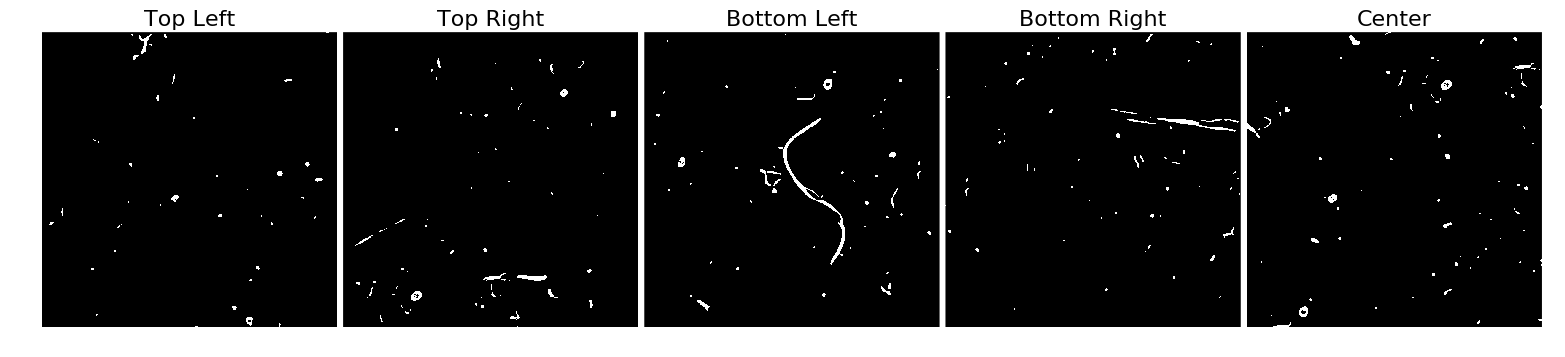

BAND (low is blue; high is red; rescaled for each facet)


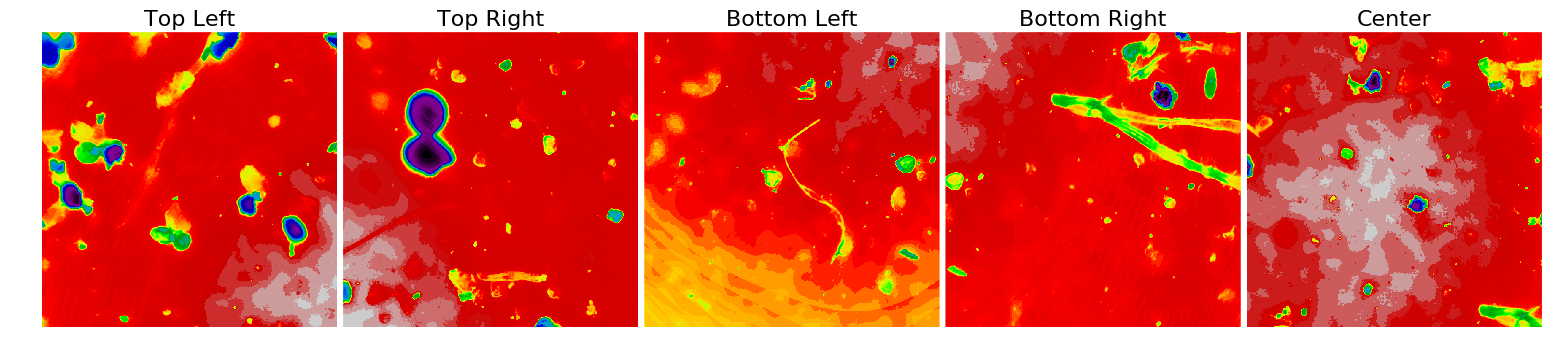

ORIGINAL OBJECTS


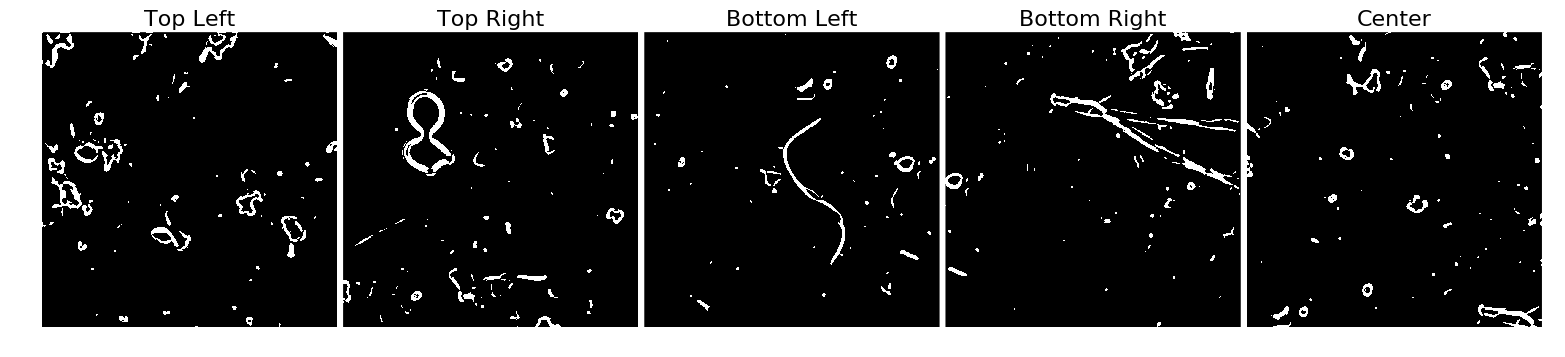

In [67]:
#########################################################################################
color_args_1 = {'colorspace'  : 'rgb',  # Colorspace from which to select band
                'target_band' : 2,      # Band of colorspace
                'low'         : 0.33,    # minimum of range for color value (as float, passes to pyroots._in_range uses)
                'high'        : 0.45,   # maximum of range for color value
                'percent'     : 60}     # minimum percent of all pixels that must fall with the range

colorargs = color_args_1  # update this when you add new bands. Suggest naming sequentially.

# run_on = morph_filt
run_on = thresh
#########################################################################################

# for viewing
try:
    colorband = getattr(color, 'rgb2' + colorargs['colorspace'])(image)
except:
    colorband = image.copy()
colorband = img_as_float(pr.img_split(colorband)[colorargs['target_band']])

colorfilt = pr.color_filter(image, run_on, **colorargs)  # image is the original input image

####### Update this, as well, for multiple bands
colorfilt1 = colorfilt  # image is the original input image

if plot is True:
    print('99.5%: ' + str(np.percentile(colorband, 99.5)))
    print('50%: ' + str(np.percentile(colorband, 50)))
    print('0.5%: ' + str(np.percentile(colorband, 0.5)))
    print('\nFILTERED OBJECTS')
    img = colorfilt
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)
    print('BAND (low is blue; high is red; rescaled for each facet)')
    img = colorband
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names, color_map="spectral")
    print('ORIGINAL OBJECTS')
    img = thresh
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)

### Color Filter 2
Saturation in HSV: Background and objects have high values; objects have relatively low values but variability is large.
Based on the previous color filter, the most important object to remove is the quarter circle in the top right. Fortunately, this has higher saturation than most of the hyphae (which is why this band was chosen). Note the low value of `percent`, and that `low` is just below the floor of the values range. 

Again, tolerance is +/-5 `percent` and +/- 0.01 `low` and `high`. 

I did lose a small piece of hyphae in the top right; this very faint bit is acceptable.

In [68]:
#########################################################################################
color_args_2 = {'colorspace'  : 'hsv',  # Colorspace from which to select band
                'target_band' : 1,      # Band of colorspace
                'low'         : 0.50,    # minimum of range for color value
                'high'        : 0.56,   # maximum of range for color value
                'percent'     : 50}    # minimum percent of all pixels that must fall with the range
color_args_2 = None

run_on = thresh
# run_on = morph_filt

colorargs = color_args_2  # update this when you add new bands. Suggest naming sequentially.
#########################################################################################

if colorargs is not None:
    colorband = getattr(color, 'rgb2' + colorargs['colorspace'])(image)
    colorband = img_as_float(pr.img_split(colorband)[colorargs['target_band']])
    colorfilt = pr.color_filter(image, run_on, **colorargs)  # image is the original input image
else:
    colorfilt = np.ones(run_on.shape)  # to save changing code later

####### Update this, as well, for multiple bands
colorfilt2 = colorfilt  # image is the original input image

if plot is True:
    if colorargs is not None:
        print('99.5%: ' + str(np.percentile(colorband, 99.5)))
        print('50%: ' + str(np.percentile(colorband, 50)))
        print('0.5%: ' + str(np.percentile(colorband, 0.5)))
        print('\nFILTERED OBJECTS')
        img = colorfilt
        pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)
        print('BAND (low is blue; high is red; rescaled for each facet)')
        img = colorband
        pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names, color_map="spectral")
        print('ORIGINAL OBJECTS')
        img = thresh
        pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)

### Combine Filters

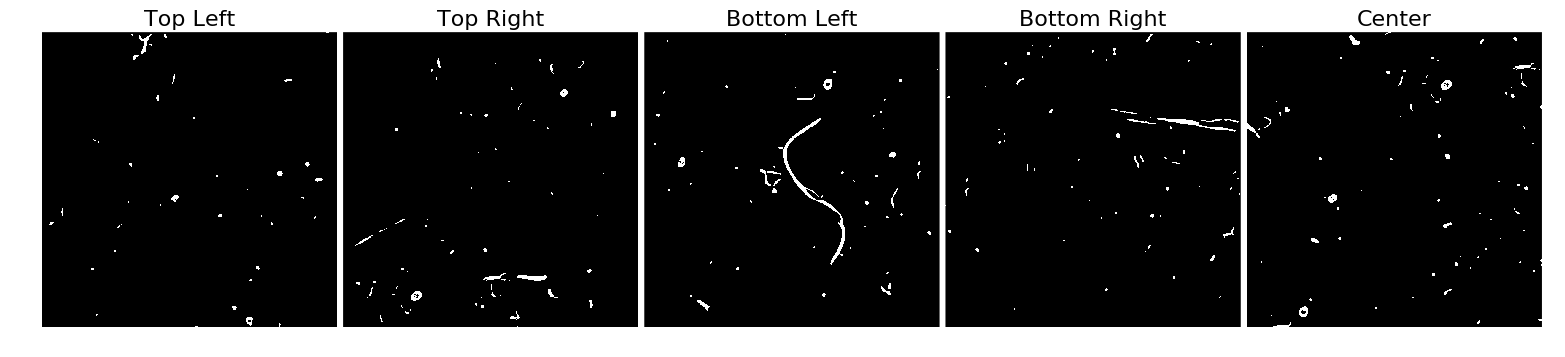

In [69]:
colorfilt = colorfilt1 * colorfilt2
img = colorfilt
if plot is True: pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)

## 8. Filtering based on morphology
This filter removes objects based on the properties of the convex hull, and also of ellipses that have equivalent second moments to the convex hull. The properties are:
* eccentricity: of an ellipse with equivalent moments to the object's convex hull. Should be very high, since hyphae are mostly long and skinny.
* solidity: Percentage of convex hull's area that an object take up. Should be low, since hyphae are curvy and skinny. 
* major axis length: of ellipse with equivalent moments to convex hull. 
* area: in pixels of each object.

Eccentricity and solidity are combined into levels of filters:
1. A 'strict' filter, with stringent eccentricity and solidity thresholds. True objects must pass one.
2. A 'loose' filter, which sets a maximum stringency and minimum eccentricity. True objects must pass both. 

Set the values to allow leeway in either direction. It is helpful to run it on the thresholded image, rather than the color-filter image, to see how tolerances are important. See <a href="https://github.com/pme1123/pyroots/blob/master/pyroots/geometry_filters.py"> documentation</a>.

Long, skinny, but hollow objects will be removed with the next filter. 

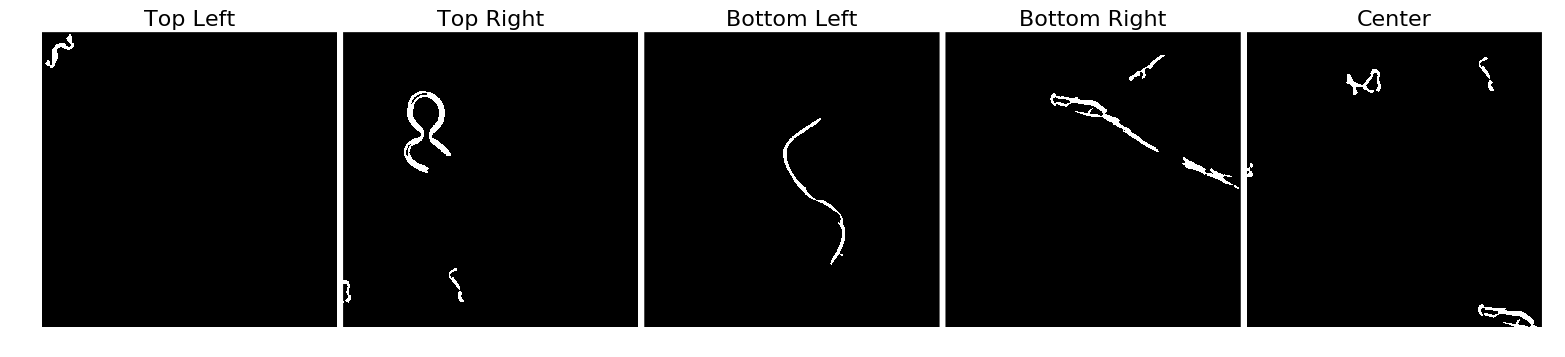

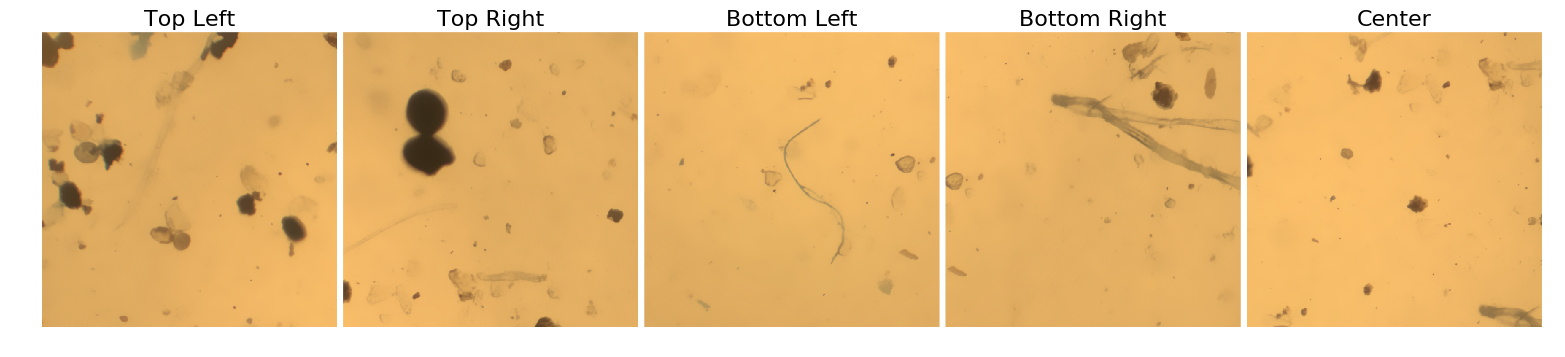

In [70]:
#########################################################################################
morphology_args = {'loose_eccentricity'  : 0.6,   # This is a floor.
                   'loose_solidity'      : 0.7,   # This is a ceiling.
                   'strict_eccentricity' : 0.95,  # Floor.
                   'strict_solidity'     : 0.4,   # Ceiling.
                   'min_length'          : 100,    # Floor.
                   'min_size'            : 300}   # Floor.
run_on = thresh  # uncomment to run on the raw objects from the frangi enhancement
# run_on = colorfilt  # uncomment to run on the objects filtered by color
#########################################################################################

morph_filt = pr.morphology_filter(run_on, **morphology_args)

if plot is True:
    img = morph_filt
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)
    img = image
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)

## 9. Filter by hollowness
Some objects are long and skinny and have the right color as true objects, but are not. These include really wide objects that were picked up as edges, clear objects with strong parallel edges, etc. They show up as hollow in binary images, and as a result, can be filtered by the ratio of A to B, where:
* A = the medial axis length of the candidate object, similar to the perimeter
* B = the medial axis length of the candidate object after filling the open gaps
This is a slower function, and so should be performed last in the filtering chain. It uses `skimage.morphology.binary_closing` to fill holes, which is more tolerant to long, skinny holes than `remove_small_holes`. See <a href="https://github.com/pme1123/pyroots/blob/master/pyroots/geometry_filters.py"> documentation</a>.

Parameters:
* fill_kernel : Dictates how wide of a gap can be filled. True objects can have loops, but usually they are large compared to edges of larger objects. A value of 15 (default) fills spaces up to 30 pixels wide. 
* threshold : maximum perimiter:filled axis ratio. Solid hyphae should have a ratio close to 1; parallel edges a ratio close to 2. 

Again, it is helpful to set this on a non-filtered, over- and under-thresholded binary image of candidate objects to set appropriate parameters. The ratio is probably larger than expected, due to some small noise loops being present on some objects (which we will take care of next).

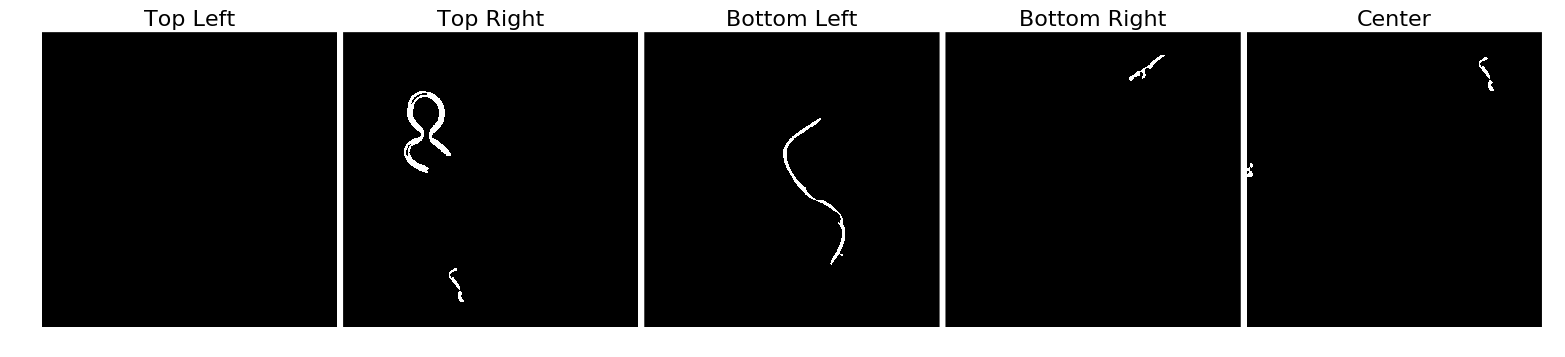

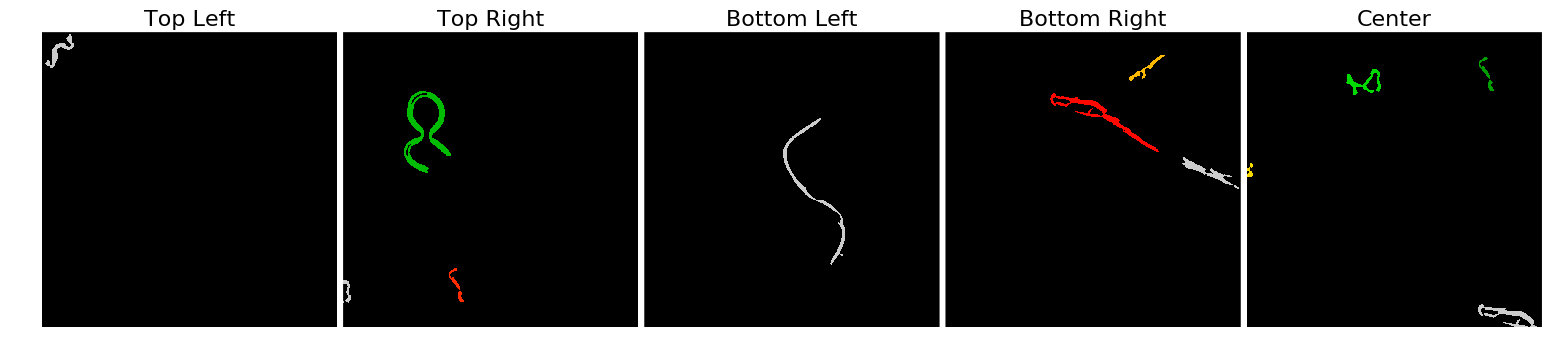

In [73]:
#########################################################################################
hollow_args = {'ratio'       : 1.5,  # this is a ceiling
               'fill_kernel' : 15}   # radius of disk, in pixels, passed to binary_closing
# run_on = thresh      # uncomment to run on the raw objects from the frangi enhancement
# run_on = colorfilt   # uncomment to run on the objects filtered by color
run_on = morph_filt  # uncomment to run on the objects filtered by morphology.
#########################################################################################

try:
    hollow_filt = pr.hollow_filter(run_on, **hollow_args)
    if plot is True:
        img = hollow_filt
        pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)
        img = ndimage.label(morph_filt)[0]
        pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names, color_map = "spectral")
except:
    print("No Updates")
    hollow_filt = np.ones(thresh.shape)

## 10. Combine Filters and Check Results.
Generally, only keep objects that pass all three filter sets. Did you keep (almost all) of what you wanted, and nothing else? 
* **If so**: Continue
* **If not**: Try changing thresholding offsets or frangi sensitivity first. Pay special attention to connectivity of candidate objects in the initial thresholding image.

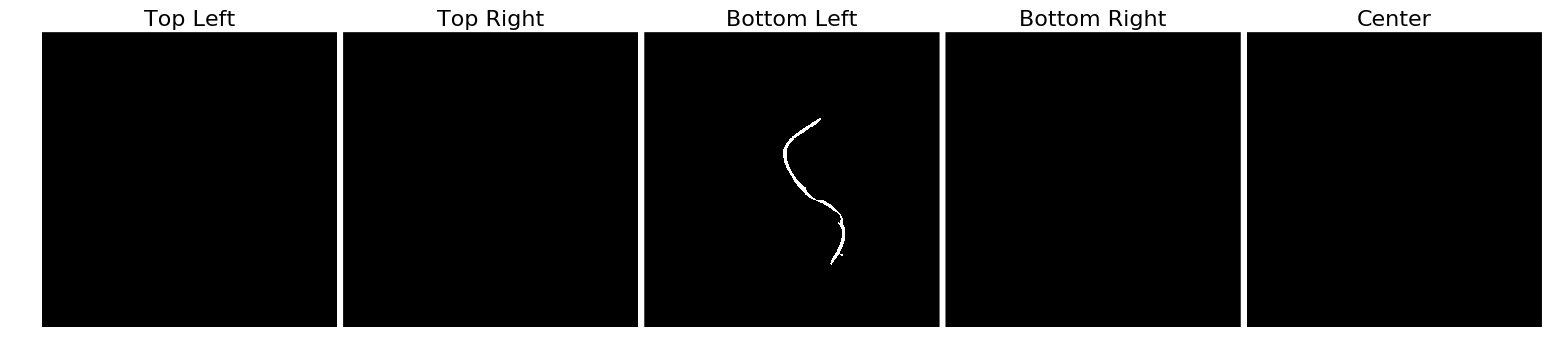

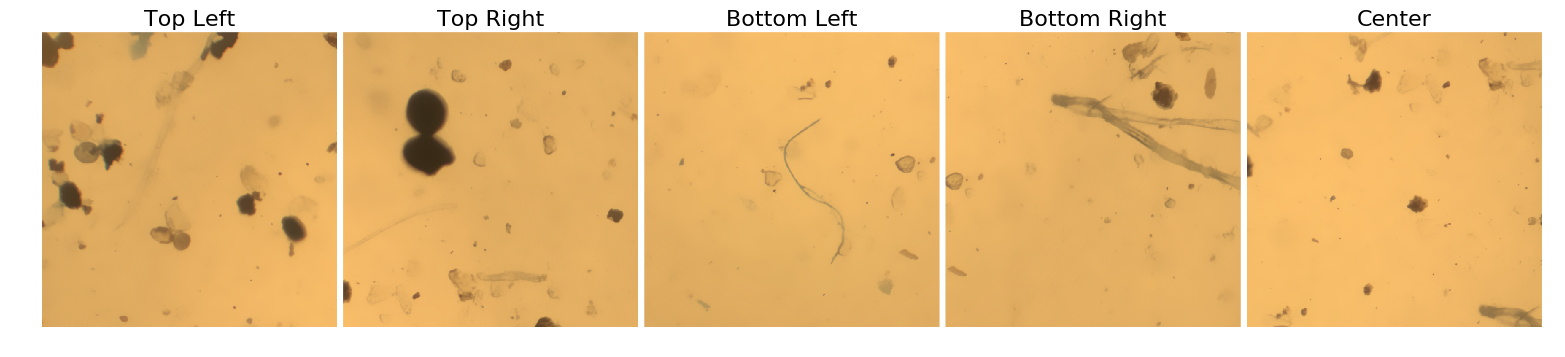

In [74]:
filt = colorfilt * morph_filt * hollow_filt

if plot is True:
    img = filt
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)
    img = image
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)

## 11. Fill small holes and close small gaps in true objects
This step closes small gaps and holes. The gaps underestimate true object length; the holes lead to overestimation. 

Hole filling and gap closing uses `skimage.morphology.binary_closing`, which preserves edge width. `min_size` is used for `skimage.morphology.remove_small_holes` after closing the image, and represents a floor area in pixels that is considered to be a true gap or hole in the object, such as when roots/hyphae cross and loop. The call to the median filter is optional but reduces small burrs that throw off the medial axis algorithm. <a href="http://scikit-image.org/docs/dev/api/skimage.filters.html"> Documentation</a>.

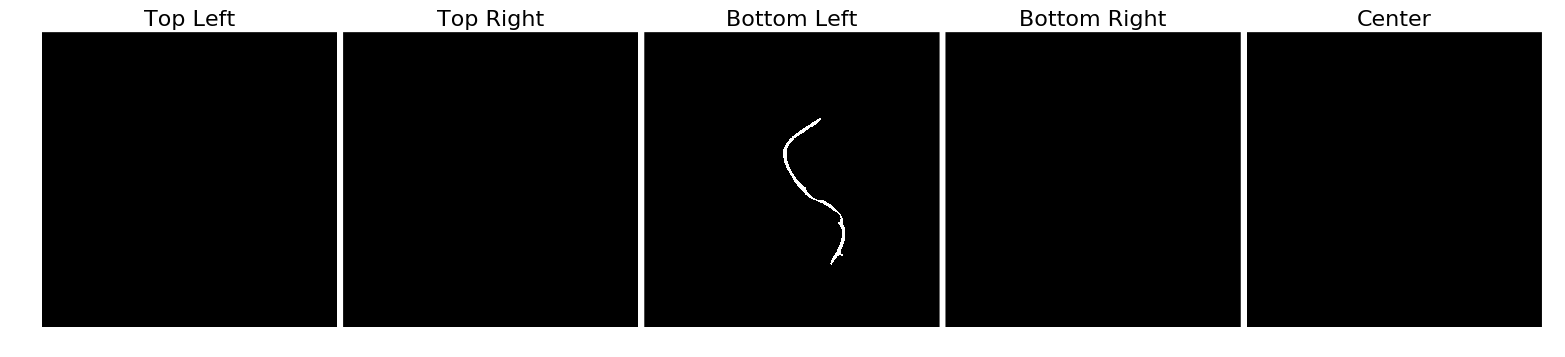

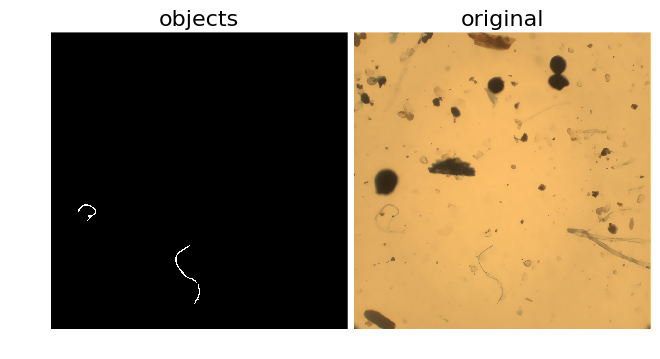

In [75]:
#########################################################################################
hole_filling = {'closing'  : morphology.disk(7),  # radius of 7 pixels; fills up to 28 px wide spaces
                'min_size' : 300}                 # area in pixels.
#########################################################################################

holes_filled = morphology.binary_closing(filt, hole_filling['closing'])
holes_filled = morphology.remove_small_holes(holes_filled, min_size = hole_filling['min_size'])
holes_filled = filters.median(holes_filled, selem=np.ones((3,3)))

if plot is True:
    img = holes_filled
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)
    img = [holes_filled, image]
    pr.multi_image_plot(img, ['objects', 'original'])

## 12. Compute skeleton
Perform medial axis skeletonization of the image, and calculate the lenth of each ixelin that image. See <a href="https://github.com/pme1123/pyroots/blob/master/pyroots/skeletonization.py"> documentation</a>.
This function returns a dictionary with keys:
- `"geometry"` - Length and diameter of each object, including background
- `"objects"` - binary immage
- `"diameter"` - array with medial axis diameter shown by color.
- `"length"` - array with medial axis length at each pixel shown by color

   Diameter   Length
0  0.000000    0.000
1  7.758453  216.843
2  7.406716  472.286


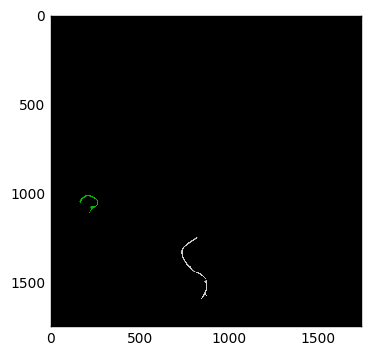

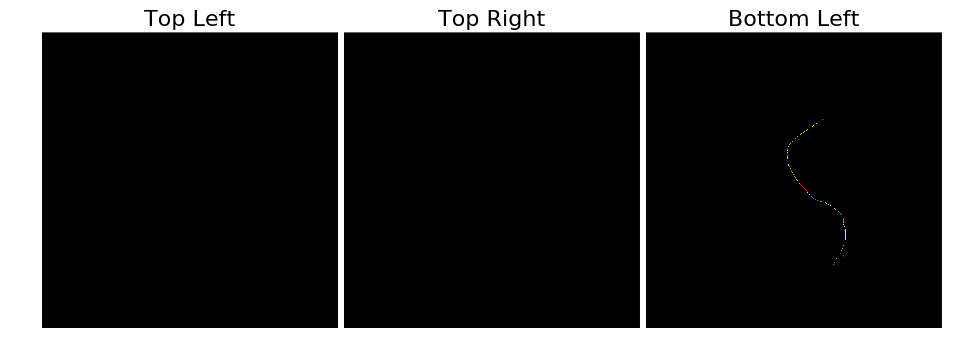

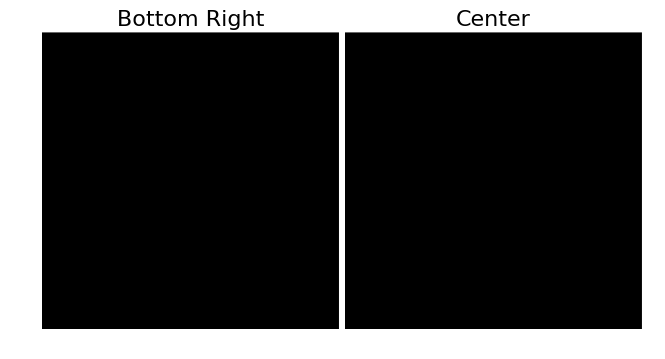

In [76]:
#############################################################
# Nothing to change here
#############################################################

skel = pr.skeleton_with_distance(holes_filled)

if plot is True:
    print(skel['geometry'])
    img = ndimage.label(skel['objects'])[0]
    plt.imshow(img, cmap="spectral")
    img = skel['diameter']
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list[0:3]], zoom_names[0:3], color_map = "spectral")
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list[3:5]], zoom_names[3:5], color_map = "spectral")

# Filter by Mean Diameter

Remove objects that are narrower than a given threshold (on average), or wider than a given threshold (on average).

Uses `pyroots.diameter_filter`.

   Diameter   Length
0  0.000000    0.000
1  7.869526  212.741
2  7.490144  465.421


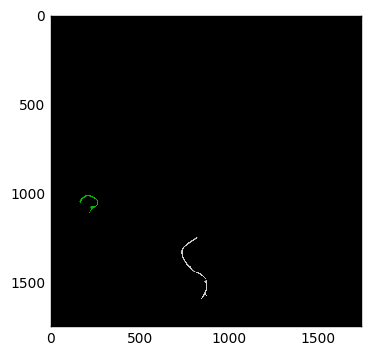

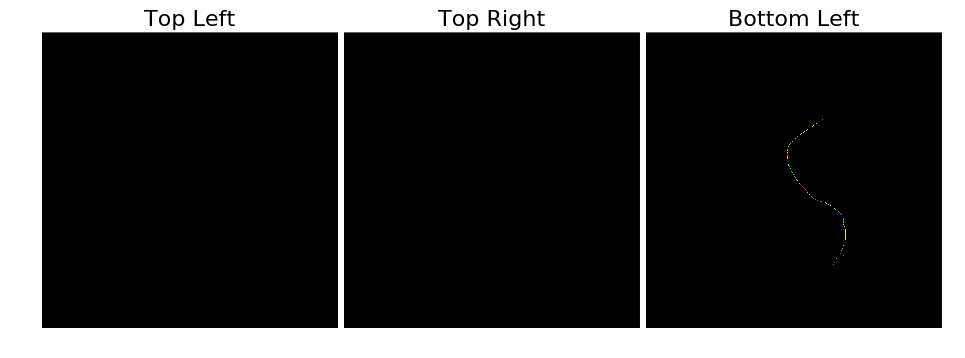

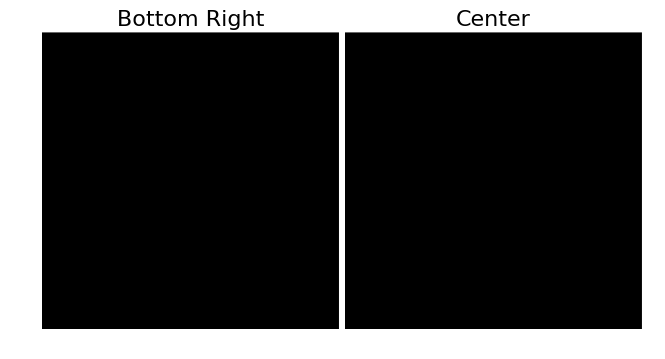

In [77]:
################################################################
diameter_args = {'max_diameter'   : 100,
                 'min_diameter'   : 3,
                 'max_percentile' : 100,
                 'min_percentile' : 40,  
                 'pixel_level'    : True}    # remove individual pixels that don't meet max/min requirements?
################################################################

diam = pr.diameter_filter(skel, **diameter_args)

if plot is True:
    print(diam['geometry'])
    img = ndimage.label(diam['objects'])[0]
    plt.imshow(img, cmap="spectral")
    img = diam['diameter']
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list[0:3]], zoom_names[0:3], color_map = "spectral")
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list[3:5]], zoom_names[3:5], color_map = "spectral")

## 13. Summarize
Summarize the objects in the image. Options center around:
- Binning pixels by diameter class
- Aggregating all objects.

Diameter class is approximate in this case, due to the frangi filter response being correlated with object width, but also strongly related to object visibility. For more accurate diameters, try the thresholding approach of `pyroots_analysis`. 

In [78]:
################################################################
diameter_bins = None
image_name = "image"
################################################################

if diameter_bins is None:
    summary_df = pr.summarize_geometry(diam['geometry'], image_name)

else:
    diam_out, summary_df = pr.bin_by_diameter(diam_dict['length'],
                                              diam_dict['diameter'],
                                              diameter_bins,
                                              image_name)

if plot is True: print(summary_df)

  ImageName   Length  NObjects  MeanDiam
0     image  678.162         2  7.609157


## 14. Save the parameters for later use

In [79]:
################################################################
settings_path = '/home/patrick/Documents/Jan25_HLD_Test/Settings/'
settings_name = 'Jan25_HLD_Test_Settings.py'  # arbitrary extension for clarity
write = False                                 # update items as changed? 
################################################################

dicts = ['colors', 'frangi_args', 'threshold_args', 
         'color_args_1', 'color_args_2', 'morphology_args', 
         'hollow_args', 'hole_filling', 'diameter_args', 
         'diameter_bins']

if write is True:
    with open(settings_path + settings_name, 'w') as file:
        for i in dicts:
            print(i + " = " + str(locals()[i]), file=file)

    for i in dicts:
        print(i + " = " + str(locals()[i]))

colors = {'band': 0, 'colorspace': 'rgb'}
frangi_args = {'beta1': 0.99, 'scale_step': 1, 'beta2': 0.03, 'black_ridges': True, 'scale_range': (2, 8)}
threshold_args = {'block_size': 29, 'offset': 0.09}
color_args_1 = {'low': 0.33, 'percent': 60, 'high': 0.45, 'target_band': 2, 'colorspace': 'rgb'}
color_args_2 = None
morphology_args = {'min_length': 100, 'loose_solidity': 0.7, 'strict_eccentricity': 0.95, 'min_size': 300, 'loose_eccentricity': 0.6, 'strict_solidity': 0.4}
hollow_args = {'fill_kernel': 15, 'ratio': 1.5}
hole_filling = {'min_size': 300, 'closing': array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],


# Run on all images
To run this as a batch, either use the cell below with the image loop (make sure all dictionaries above are loaded into the environment) or run in the terminal. The latter option might be better for lots of threads (i.e. supercomputers). If running in this notebook, check your resource usage first and ensure you have enough RAM (~50 MB/thread for a 7MB image).

## Option 1: Run In Notebook
First, make sure the full function behaves. Zoom in to get a better look at skeletons. 

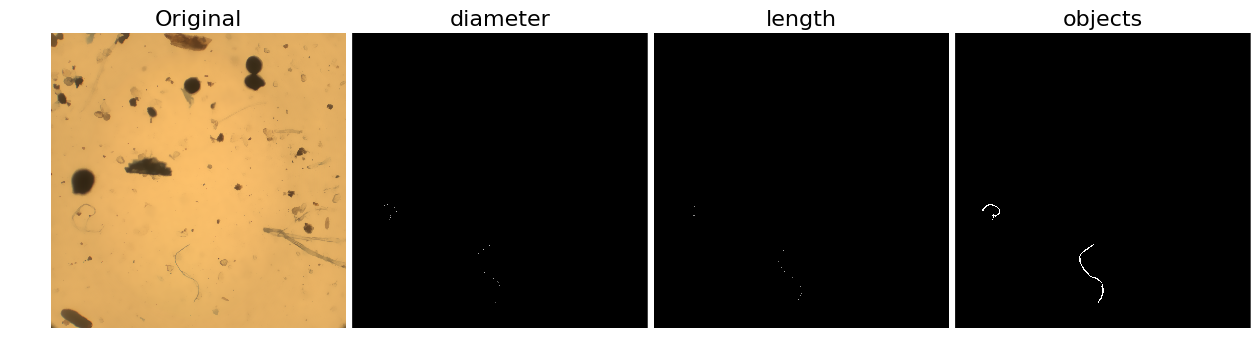

  ImageName   Length  NObjects  MeanDiam
0     image  699.969         2  7.308349


In [80]:
test = True
if test is True:
    
    test_out = pr.frangi_segmentation(image, colors, frangi_args, threshold_args,
                                      color_args_1, color_args_2, 
                                      morphology_args, hollow_args, hole_filling, 
                                      diameter_args, diameter_bins, image_name="image")

    img = ['diameter', 'length', 'objects']
    pr.multi_image_plot([image] + [test_out[i] for i in img], ["Original"] + img)
    print(test_out['geometry'])

Now run the loop

In [84]:
############################################################################
loop_args = {'base_directory'  : '/home/patrick/Documents/Jan25_HLD_Test/Pyroots_Preprocessed',  # where are the images?
             'image_extension' : ".tif",
             'save_images'     : True,                           # save objects images? Recommended for verification.
             'out_dir'         : 'Pyroots Analyzed',             # path to save objects images
             'table_out'       : 'Pyroots_Analyzed.txt',         # file name of export table
             'params'          : settings_path + settings_name,  # path to parameters file 
             'threads'         : 4}                              # parallel processing

warning_preference = 'ignore'     # ignore warnings raised by various functions? Most aren't useful...
# warning_preference = 'default'
############################################################################

loop = False      # S-L-O-W for many images (~10 sec / img*thread)
if loop is True:
    warnings.filterwarnings(warning_preference)
    x = pr.frangi_image_loop(**loop_args)

    x.to_csv(loop_args['base_directory'] + os.sep + 'PR_OUT.csv')  # second copy, in case of error in the loop. 